<!-- Copyright (c) 2021-2024, InterDigital Communications, Inc
All rights reserved.

Redistribution and use in source and binary forms, with or without 
modification, are permitted (subject to the limitations in the disclaimer 
below) provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.
* Neither the name of InterDigital Communications, Inc nor the names of its 
contributors may be used to endorse or promote products derived from this 
software without specific prior written permission.

NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY 
THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND 
CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT 
NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A 
PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER 
OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, 
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; 
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR 
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF 
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. -->

# Compressai Models Comparison Demo

In [1]:
import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
from pytorch_msssim import ms_ssim

## Load the model in compressAI
*  **Cheng2020** : `cheng2020_attn`   
    Self-attention model variant from “Learned Image Compression with Discretized Gaussian Mixture Likelihoods and Attention Modules”, by Zhengxue Cheng, Heming Sun, Masaru Takeuchi, Jiro Katto.

* **Minnen2018** : `mbt2018`    
    Joint Autoregressive Hierarchical Priors model from D. Minnen, J. Balle, G.D. Toderici: “Joint Autoregressive and Hierarchical Priors for Learned Image Compression”, Adv. in Neural Information Processing Systems 31 (NeurIPS 2018). 

In [3]:
from compressai.zoo import (mbt2018, cheng2020_attn)

/home/ccwu/miniforge3/envs/compressai/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
from ipywidgets import interact, widgets

## Global settings

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metric = 'mse'  # only pre-trained model for mse are available for now
quality = 3     # lower quality -> lower bit-rate (use lower quality to clearly see visual differences in the notebook)

## Load the Model in "The Devil Is in the Details: Window-based Attention for Image Compression"

In [6]:
from compressai.models import WACNN
from compressai.models import SymmetricalTransFormer

## Load the pretrained models

In [7]:
networks = {
    'Minnen2018': mbt2018(quality=quality, pretrained=True).eval().to(device),
    'Cheng2020' : cheng2020_attn(quality=quality, pretrained=True).eval().to(device),
    'WACNN': WACNN(N=192, M=320).eval().to(device),
    'STF': SymmetricalTransFormer(
        pretrain_img_size=256,
        patch_size=2,
        embed_dim=48,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=4,
        num_slices=12
    ).eval().to(device)
}

/home/ccwu/miniforge3/envs/compressai/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
# Load STF pre-trained model
stf_weight_path = "../ckpt/stf_0067_best.pth.tar" # <- Change here if want to load another pre-trainned model
stf_checkpoint = torch.load(stf_weight_path, map_location=device)
stf_state_dict = {k.replace('module.', ''): v for k, v in stf_checkpoint['state_dict'].items()}

networks['STF'] = SymmetricalTransFormer(
    pretrain_img_size=256,
    patch_size=2,
    embed_dim=48,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=4,
    num_slices=12
).eval().to(device)
try:
    networks['STF'].load_state_dict(stf_state_dict)
    print("STF loaded successfully!")
except Exception as e:
    print(f"Error loading STF: {e}")

# Load WACNN pre-trained model
cnn_weight_path = "../ckpt/cnn_0067_best.pth.tar" # <- Change here if want to load another pre-trainned model
cnn_checkpoint = torch.load(cnn_weight_path, map_location=device)
cnn_state_dict = {k.replace('module.', ''): v for k, v in cnn_checkpoint['state_dict'].items()}

wacnn_model = WACNN(N=192, M=320).to(device)
try:
    wacnn_model.load_state_dict(cnn_state_dict)
    print("WACNN loaded successfully!")
except Exception as e:
    print(f"Error loading WACNN: {e}")

wacnn_model.eval()
wacnn_model.update(force=True)
networks['WACNN'] = wacnn_model

STF loaded successfully!
WACNN loaded successfully!


## Inference

### Load input data

In [11]:
img = Image.oimg = Image.open('../eval_dataset/kodak/kodim24.png').convert('RGB')
# img = Image.oimg = Image.open('../eval_dataset/CLIC_professional_valid_2020/vita-vilcina-3055.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

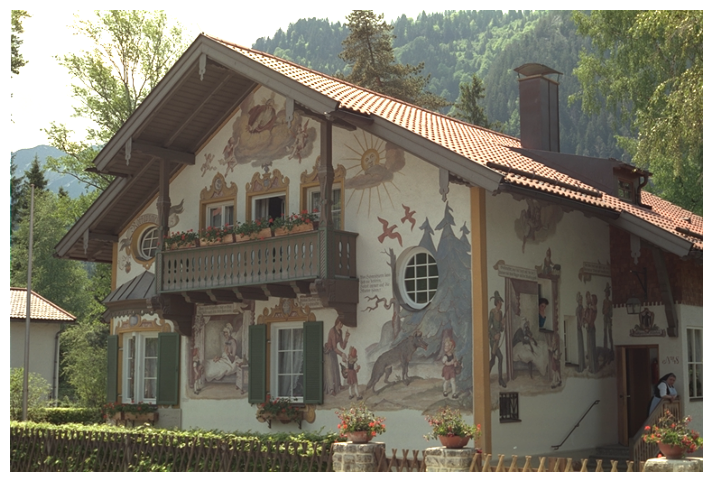

In [12]:
%matplotlib inline
plt.figure(figsize=(9, 6))
plt.axis('off')
plt.imshow(img)
plt.show()

### Run the networks

In [13]:
outputs = {}
with torch.no_grad():
    for name, net in networks.items():
        rv = net(x)
        rv['x_hat'].clamp_(0, 1)
        outputs[name] = rv

### Visualize the reconstructions

In [14]:
reconstructions = {name: transforms.ToPILImage()(out['x_hat'].squeeze())
                  for name, out in outputs.items()}

In [15]:
diffs = [torch.mean((out['x_hat'] - x).abs(), axis=1).squeeze()
        for out in outputs.values()]

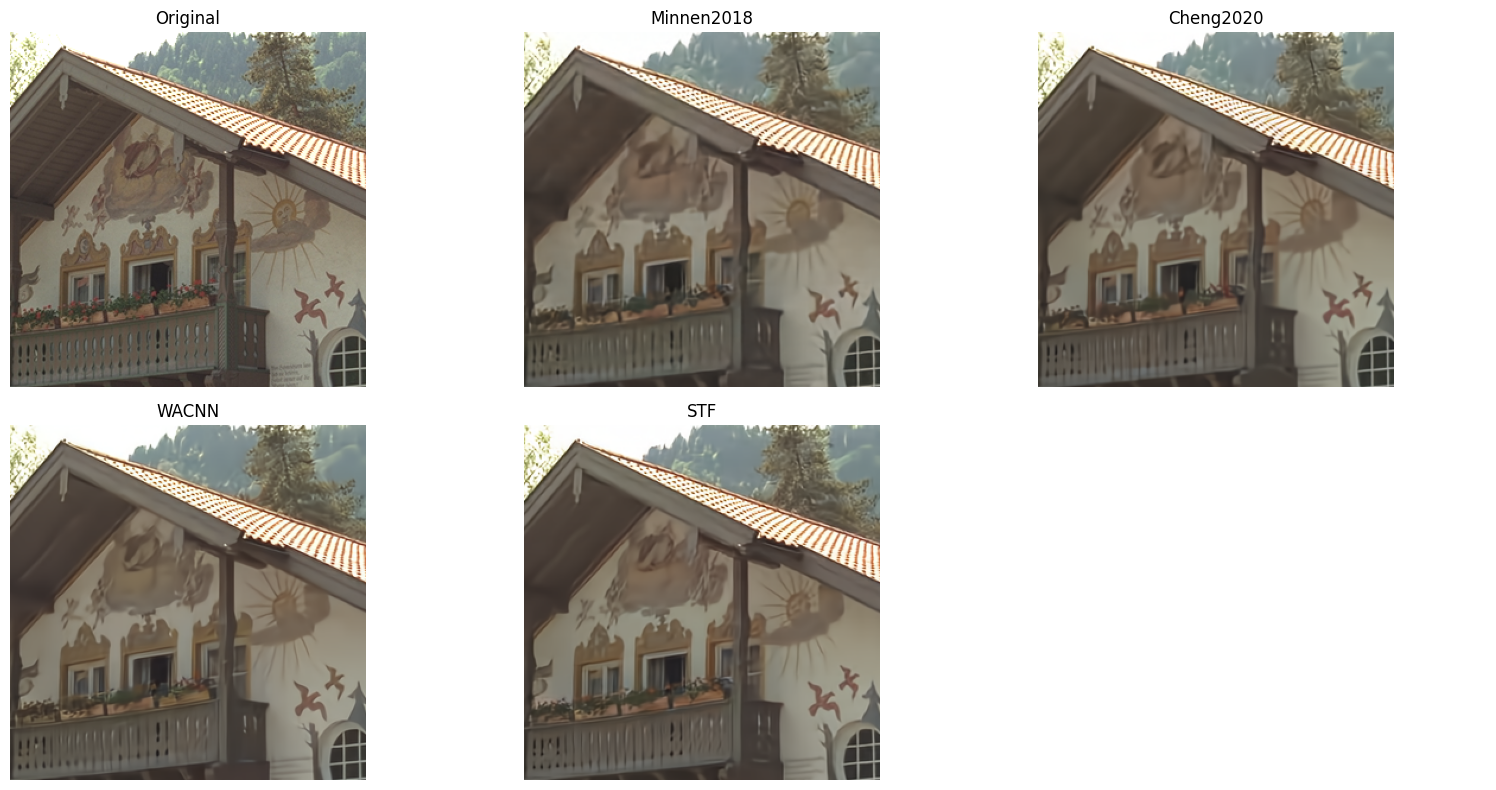

In [21]:
%matplotlib inline
n_models = len(reconstructions) + 1  # +1 for original image
n_rows = (n_models + 2) // 3  # 每行3張圖
fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4*n_rows))

# 關閉所有軸
for ax in axes.ravel():
    ax.axis('off')

size = (168, 12, 468, 312)
# 顯示原圖
axes.ravel()[0].imshow(img.crop(size))
axes.ravel()[0].title.set_text('Original')

# 顯示各個模型的重建結果
for i, (name, rec) in enumerate(reconstructions.items()):
    ax = axes.ravel()[i + 1]
    ax.imshow(rec.crop(size))
    ax.title.set_text(f'{name}')

plt.tight_layout()
plt.show()

## Metric

In [120]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [121]:
metrics = {}
for name, out in outputs.items():
    metrics[name] = {
        'psnr': compute_psnr(x, out["x_hat"]),
        'ms-ssim': compute_msssim(x, out["x_hat"]),
        'bit-rate': compute_bpp(out),
    }

In [122]:
header = f'{"Model":20s} | {"PSNR [dB]"} | {"MS-SSIM":<9s} | {"Bpp":<9s}|'
print('-'*len(header))
print(header)
print('-'*len(header))
for name, m in metrics.items():
    print(f'{name:20s}', end='')
    for v in m.values():
        print(f' | {v:9.3f}', end='')
    print('|')
print('-'*len(header))

---------------------------------------------------------
Model                | PSNR [dB] | MS-SSIM   | Bpp      |
---------------------------------------------------------
Minnen2018           |    24.749 |     0.944 |     0.242|
Cheng2020            |    25.773 |     0.953 |     0.253|
WACNN                |    28.334 |     0.969 |     0.379|
STF                  |    27.809 |     0.967 |     0.356|
---------------------------------------------------------


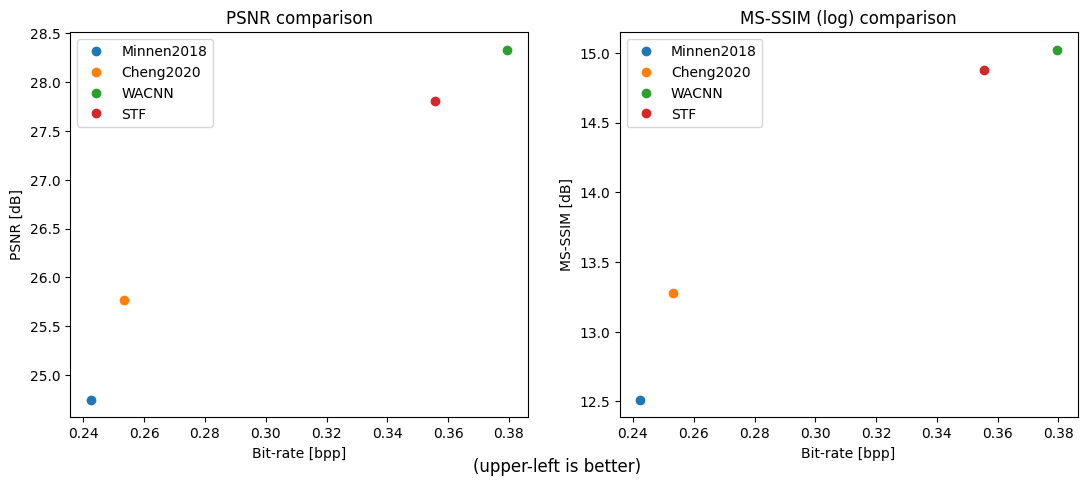

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.figtext(.5, 0., '(upper-left is better)', fontsize=12, ha='center')
for name, m in metrics.items():
    axes[0].plot(m['bit-rate'], m['psnr'], 'o', label=name)
    axes[0].legend(loc='best')
    axes[0].grid()
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')

    axes[1].plot(m['bit-rate'], -10*np.log10(1-m['ms-ssim']), 'o', label=name)
    axes[1].legend(loc='best')
    axes[1].grid()
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM (log) comparison')

plt.show()

## Evaulate all the given pre-trained model

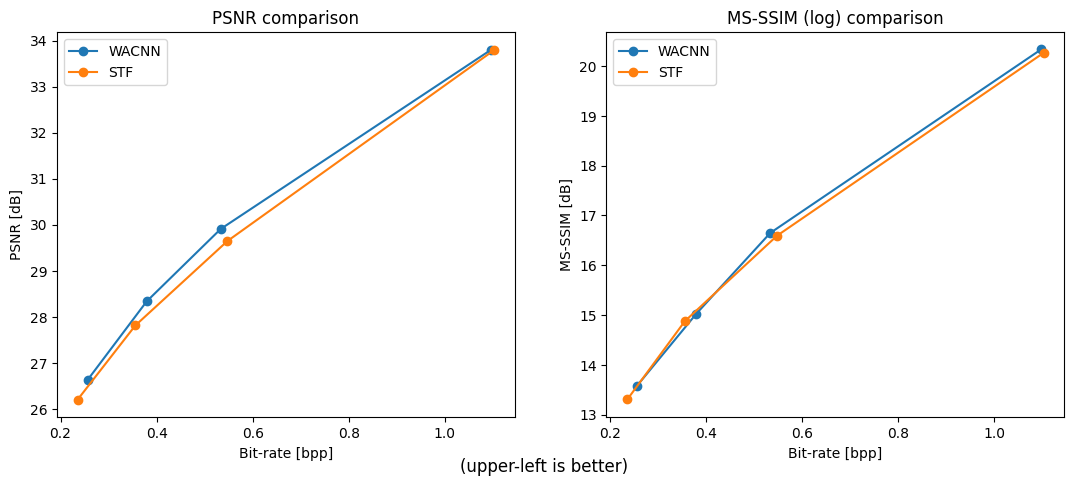

In [80]:
def evaluate_model(net, img):
    with torch.no_grad():
        rv = net(img)
        rv['x_hat'].clamp_(0, 1)
        return {
            'psnr': compute_psnr(img, rv["x_hat"]),
            'ms-ssim': compute_msssim(img, rv["x_hat"]),
            'bit-rate': compute_bpp(rv),
        }

# 預定義 lambda 值和對應的檔案名
lambda_values = ['0018', '0035', '0067', '025']
metrics = {
    'WACNN': {'bit-rate': [], 'psnr': [], 'ms-ssim': []},
    'STF': {'bit-rate': [], 'psnr': [], 'ms-ssim': []}
}

# 評估每個 lambda 值的模型
for lambda_val in lambda_values:
    # 載入 WACNN model
    cnn_path = f"../ckpt/cnn_{lambda_val}_best.pth.tar"
    cnn_checkpoint = torch.load(cnn_path, map_location=device)
    cnn_state_dict = {k.replace('module.', ''): v for k, v in cnn_checkpoint['state_dict'].items()}
    wacnn_model = WACNN(N=192, M=320).to(device)
    wacnn_model.load_state_dict(cnn_state_dict)
    wacnn_model.eval()
    wacnn_model.update(force=True)
    
    # 評估 WACNN
    results = evaluate_model(wacnn_model, x)
    metrics['WACNN']['bit-rate'].append(results['bit-rate'])
    metrics['WACNN']['psnr'].append(results['psnr'])
    metrics['WACNN']['ms-ssim'].append(results['ms-ssim'])
    
    # 載入 STF model
    stf_path = f"../ckpt/stf_{lambda_val}_best.pth.tar"
    stf_checkpoint = torch.load(stf_path, map_location=device)
    stf_state_dict = {k.replace('module.', ''): v for k, v in stf_checkpoint['state_dict'].items()}
    stf_model = SymmetricalTransFormer(
        pretrain_img_size=256,
        patch_size=2,
        embed_dim=48,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=4,
        num_slices=12
    ).eval().to(device)
    stf_model.load_state_dict(stf_state_dict)
    
    # 評估 STF
    results = evaluate_model(stf_model, x)
    metrics['STF']['bit-rate'].append(results['bit-rate'])
    metrics['STF']['psnr'].append(results['psnr'])
    metrics['STF']['ms-ssim'].append(results['ms-ssim'])

# 繪製圖表
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.figtext(.5, 0., '(upper-left is better)', fontsize=12, ha='center')

for name, m in metrics.items():
    # 排序點以便正確繪製線條
    points = sorted(zip(m['bit-rate'], m['psnr'], m['ms-ssim']))
    bit_rates, psnrs, ms_ssims = zip(*points)
    
    # PSNR plot
    axes[0].plot(bit_rates, psnrs, 'o-', label=name)  # 添加 '-' 來連接點
    axes[0].legend(loc='best')
    axes[0].grid()
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')

    # MS-SSIM plot
    axes[1].plot(bit_rates, [-10*np.log10(1-msssim) for msssim in ms_ssims], 'o-', label=name)
    axes[1].legend(loc='best')
    axes[1].grid()
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM (log) comparison')

plt.show()

留 1 2 3 5

In [130]:
# 在需要時清理內存
import gc

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

# 在處理新批次前清理
clear_gpu_memory()